In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("C:\\Users\\sdprh\\Downloads\\employee_shrinkage_latest.xlsx") 
df.head(10)

,Date,Segment,Number_of_Employees,Total_Worked_Hours,Productive_Hours,Breaks,Lunch,Meetings,Training,Project,...,MIA,Tech_Issues,Callin,Bereavement,FMLA,NCNS,Others (Unplanned),Planned_Unproductive_Hours,Unplanned_Unproductive_Hours,Shrinkage_Percentage
0,2020-01-01,Customer Support,84,3360,2369,117,145,75,96,72,...,45,34,28,27,45,56,18,712,279,29.494048
1,2020-01-01,Quality Assurance (QA),83,3320,2327,116,145,77,95,70,...,49,33,26,29,45,59,14,713,280,29.909639
2,2020-01-01,Back Office/Operations,89,3560,2564,115,146,77,96,79,...,45,31,26,26,46,56,12,725,271,27.977528
3,2020-01-01,Training and Development,97,3880,2891,118,146,75,99,70,...,45,31,25,25,47,55,17,718,271,25.489691
4,2020-01-01,Human Resources (HR),98,3920,2917,118,147,78,97,75,...,48,31,25,26,47,58,16,725,278,25.586735
5,2020-01-01,Workforce Management (WFM),87,3480,2475,118,146,75,95,79,...,47,34,25,28,49,57,18,722,283,28.879310
6,2020-01-01,Sales,94,3760,2759,115,146,77,96,79,...,49,33,28,27,47,56,11,724,277,26.622340
7,2020-01-01,Billing and Payments,95,3800,2792,116,145,76,99,78,...,46,33,27,26,45,55,18,729,279,26.526316
8,2020-01-01,Customer Retention/Loyalty,86,3440,2437,119,148,77,95,72,...,46,30,29,26,48,59,18,722,281,29.156977
9,2020-01-01,Compliance and Risk Management,73,2920,1928,115,147,77,99,72,...,46,34,27,27,45,57,10,719,273,33.972603


In [3]:
df['Date'] = pd.to_datetime(df['Date'])

df['Segment'] = df['Segment'].map({'Customer Support': 0, 'Quality Assurance (QA)': 1, 'Back Office/Operations': 2, 
                                   'Training and Development': 3, 'Human Resources (HR)': 4, 'Workforce Management (WFM)': 5, 
                                   'Sales': 6, 'Billing and Payments': 7, 'Customer Retention/Loyalty': 8, 
                                   'Compliance and Risk Management': 9, 'IT and Infrastructure': 10, 
                                   'Reporting and Analytics': 11, 'Outbound Campaigns': 12, 'Technical Support': 13})



In [4]:
df.head()

,Date,Segment,Number_of_Employees,Total_Worked_Hours,Productive_Hours,Breaks,Lunch,Meetings,Training,Project,...,MIA,Tech_Issues,Callin,Bereavement,FMLA,NCNS,Others (Unplanned),Planned_Unproductive_Hours,Unplanned_Unproductive_Hours,Shrinkage_Percentage
0,2020-01-01,0,84,3360,2369,117,145,75,96,72,...,45,34,28,27,45,56,18,712,279,29.494048
1,2020-01-01,1,83,3320,2327,116,145,77,95,70,...,49,33,26,29,45,59,14,713,280,29.909639
2,2020-01-01,2,89,3560,2564,115,146,77,96,79,...,45,31,26,26,46,56,12,725,271,27.977528
3,2020-01-01,3,97,3880,2891,118,146,75,99,70,...,45,31,25,25,47,55,17,718,271,25.489691
4,2020-01-01,4,98,3920,2917,118,147,78,97,75,...,48,31,25,26,47,58,16,725,278,25.586735


In [4]:
targets = ['Planned_Unproductive_Hours', 'Unplanned_Unproductive_Hours', 'Shrinkage_Percentage']
exog_columns = ['Number_of_Employees',  'Segment','Total_Worked_Hours', 'Productive_Hours']


train_df = df.iloc[:-140]  
test_df = df.iloc[-140:]  


forecasts = {}
metrics = {'Segment': [], 'Target': [], 'R2': [], 'MSE': [], 'MAE': []}



In [5]:
for target in targets:
    for segment in df['Segment'].unique():
        
        segment_train_df = train_df[train_df['Segment'] == segment]
        segment_test_df = test_df[test_df['Segment'] == segment]
        
        if segment_train_df.empty or segment_test_df.empty:
            continue
        X_train = segment_train_df[exog_columns]
        y_train = segment_train_df[target]
        X_test = segment_test_df[exog_columns]
        y_test = segment_test_df[target]
        model = ARIMA(y_train, exog=X_train, order=(5,1,0))
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=len(segment_test_df), exog=X_test)
        forecast_values = forecast.predicted_mean
        forecast_values.index = y_test.index
        segment_key = f'{target}_Segment_{segment}'
        forecasts[segment_key] = forecast_values 
        r2 = r2_score(y_test, forecast_values)
        mse = mean_squared_error(y_test, forecast_values)
        mae = mean_absolute_error(y_test, forecast_values) 
        metrics['Segment'].append(segment)
        metrics['Target'].append(target)
        metrics['R2'].append(r2)
        metrics['MSE'].append(mse)
        metrics['MAE'].append(mae)
        print(f'R^2 score for {target}, Segment {segment}: {r2:.4f}')
        print(f'MSE for {target}, Segment {segment}: {mse:.4f}')
        print(f'MAE for {target}, Segment {segment}: {mae:.4f}')

C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

R^2 score for Planned_Unproductive_Hours, Segment 0: 0.5123
MSE for Planned_Unproductive_Hours, Segment 0: 10.3821
MAE for Planned_Unproductive_Hours, Segment 0: 3.1049


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Planned_Unproductive_Hours, Segment 1: -0.7943
MSE for Planned_Unproductive_Hours, Segment 1: 19.0199
MAE for Planned_Unproductive_Hours, Segment 1: 3.6695


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Planned_Unproductive_Hours, Segment 2: -0.8928
MSE for Planned_Unproductive_Hours, Segment 2: 19.8553
MAE for Planned_Unproductive_Hours, Segment 2: 3.9556


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Planned_Unproductive_Hours, Segment 3: 0.3184
MSE for Planned_Unproductive_Hours, Segment 3: 28.4146
MAE for Planned_Unproductive_Hours, Segment 3: 4.8547


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Planned_Unproductive_Hours, Segment 4: -0.0300
MSE for Planned_Unproductive_Hours, Segment 4: 12.2058
MAE for Planned_Unproductive_Hours, Segment 4: 2.7885


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Planned_Unproductive_Hours, Segment 5: 0.3268
MSE for Planned_Unproductive_Hours, Segment 5: 16.4591
MAE for Planned_Unproductive_Hours, Segment 5: 3.4753


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Planned_Unproductive_Hours, Segment 6: 0.4135
MSE for Planned_Unproductive_Hours, Segment 6: 8.3577
MAE for Planned_Unproductive_Hours, Segment 6: 2.2576


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Planned_Unproductive_Hours, Segment 7: -0.3600
MSE for Planned_Unproductive_Hours, Segment 7: 27.7434
MAE for Planned_Unproductive_Hours, Segment 7: 4.8806


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Planned_Unproductive_Hours, Segment 8: 0.2036
MSE for Planned_Unproductive_Hours, Segment 8: 16.3739
MAE for Planned_Unproductive_Hours, Segment 8: 3.5405


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\t

R^2 score for Planned_Unproductive_Hours, Segment 9: 0.4465
MSE for Planned_Unproductive_Hours, Segment 9: 15.1708
MAE for Planned_Unproductive_Hours, Segment 9: 3.1584


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\t

R^2 score for Planned_Unproductive_Hours, Segment 10: 0.3282
MSE for Planned_Unproductive_Hours, Segment 10: 11.6885
MAE for Planned_Unproductive_Hours, Segment 10: 2.6790


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Planned_Unproductive_Hours, Segment 11: 0.2282
MSE for Planned_Unproductive_Hours, Segment 11: 19.7877
MAE for Planned_Unproductive_Hours, Segment 11: 3.4984


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Planned_Unproductive_Hours, Segment 12: 0.4481
MSE for Planned_Unproductive_Hours, Segment 12: 4.6416
MAE for Planned_Unproductive_Hours, Segment 12: 1.6778


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Planned_Unproductive_Hours, Segment 13: -0.0067
MSE for Planned_Unproductive_Hours, Segment 13: 19.3295
MAE for Planned_Unproductive_Hours, Segment 13: 3.7079


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Unplanned_Unproductive_Hours, Segment 0: 0.6072
MSE for Unplanned_Unproductive_Hours, Segment 0: 10.3740
MAE for Unplanned_Unproductive_Hours, Segment 0: 3.1027


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Unplanned_Unproductive_Hours, Segment 1: 0.3343
MSE for Unplanned_Unproductive_Hours, Segment 1: 19.0669
MAE for Unplanned_Unproductive_Hours, Segment 1: 3.6699


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Unplanned_Unproductive_Hours, Segment 2: -0.4227
MSE for Unplanned_Unproductive_Hours, Segment 2: 19.8609
MAE for Unplanned_Unproductive_Hours, Segment 2: 3.9558


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Unplanned_Unproductive_Hours, Segment 3: -0.0902
MSE for Unplanned_Unproductive_Hours, Segment 3: 28.3551
MAE for Unplanned_Unproductive_Hours, Segment 3: 4.8526


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Unplanned_Unproductive_Hours, Segment 4: 0.4710
MSE for Unplanned_Unproductive_Hours, Segment 4: 12.1937
MAE for Unplanned_Unproductive_Hours, Segment 4: 2.7888


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Unplanned_Unproductive_Hours, Segment 5: 0.5665
MSE for Unplanned_Unproductive_Hours, Segment 5: 16.4038
MAE for Unplanned_Unproductive_Hours, Segment 5: 3.4695


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Unplanned_Unproductive_Hours, Segment 6: 0.3386
MSE for Unplanned_Unproductive_Hours, Segment 6: 8.3662
MAE for Unplanned_Unproductive_Hours, Segment 6: 2.2584


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Unplanned_Unproductive_Hours, Segment 7: -0.6954
MSE for Unplanned_Unproductive_Hours, Segment 7: 27.8209
MAE for Unplanned_Unproductive_Hours, Segment 7: 4.8888


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Unplanned_Unproductive_Hours, Segment 8: -1.0803
MSE for Unplanned_Unproductive_Hours, Segment 8: 16.2470
MAE for Unplanned_Unproductive_Hours, Segment 8: 3.5303


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Unplanned_Unproductive_Hours, Segment 9: 0.4182
MSE for Unplanned_Unproductive_Hours, Segment 9: 15.1783
MAE for Unplanned_Unproductive_Hours, Segment 9: 3.1601


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Unplanned_Unproductive_Hours, Segment 10: -0.2149
MSE for Unplanned_Unproductive_Hours, Segment 10: 11.6755
MAE for Unplanned_Unproductive_Hours, Segment 10: 2.6761


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Unplanned_Unproductive_Hours, Segment 11: 0.2950
MSE for Unplanned_Unproductive_Hours, Segment 11: 19.7472
MAE for Unplanned_Unproductive_Hours, Segment 11: 3.4956


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Unplanned_Unproductive_Hours, Segment 12: 0.7071
MSE for Unplanned_Unproductive_Hours, Segment 12: 4.6422
MAE for Unplanned_Unproductive_Hours, Segment 12: 1.6765


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Unplanned_Unproductive_Hours, Segment 13: 0.4919
MSE for Unplanned_Unproductive_Hours, Segment 13: 19.3136
MAE for Unplanned_Unproductive_Hours, Segment 13: 3.7077


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Shrinkage_Percentage, Segment 0: 0.9824
MSE for Shrinkage_Percentage, Segment 0: 0.1844
MAE for Shrinkage_Percentage, Segment 0: 0.3085


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Shrinkage_Percentage, Segment 1: 0.9918
MSE for Shrinkage_Percentage, Segment 1: 0.0789
MAE for Shrinkage_Percentage, Segment 1: 0.2439


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Shrinkage_Percentage, Segment 2: 0.9889
MSE for Shrinkage_Percentage, Segment 2: 0.0918
MAE for Shrinkage_Percentage, Segment 2: 0.2515


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Shrinkage_Percentage, Segment 3: 0.9894
MSE for Shrinkage_Percentage, Segment 3: 0.0716
MAE for Shrinkage_Percentage, Segment 3: 0.2276
R^2 score for Shrinkage_Percentage, Segment 4: 0.9903
MSE for Shrinkage_Percentage, Segment 4: 0.1106
MAE for Shrinkage_Percentage, Segment 4: 0.2829


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\t

R^2 score for Shrinkage_Percentage, Segment 5: 0.9788
MSE for Shrinkage_Percentage, Segment 5: 0.1901
MAE for Shrinkage_Percentage, Segment 5: 0.4109


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Shrinkage_Percentage, Segment 6: 0.9841
MSE for Shrinkage_Percentage, Segment 6: 0.1411
MAE for Shrinkage_Percentage, Segment 6: 0.2738


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Shrinkage_Percentage, Segment 7: 0.9907
MSE for Shrinkage_Percentage, Segment 7: 0.0998
MAE for Shrinkage_Percentage, Segment 7: 0.2524


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Shrinkage_Percentage, Segment 8: 0.9899
MSE for Shrinkage_Percentage, Segment 8: 0.0901
MAE for Shrinkage_Percentage, Segment 8: 0.2707


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Shrinkage_Percentage, Segment 9: 0.9919
MSE for Shrinkage_Percentage, Segment 9: 0.0896
MAE for Shrinkage_Percentage, Segment 9: 0.2523


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\t

R^2 score for Shrinkage_Percentage, Segment 10: 0.9915
MSE for Shrinkage_Percentage, Segment 10: 0.0622
MAE for Shrinkage_Percentage, Segment 10: 0.2174


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

R^2 score for Shrinkage_Percentage, Segment 11: 0.9928
MSE for Shrinkage_Percentage, Segment 11: 0.0688
MAE for Shrinkage_Percentage, Segment 11: 0.2325


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\t

R^2 score for Shrinkage_Percentage, Segment 12: 0.9895
MSE for Shrinkage_Percentage, Segment 12: 0.1469
MAE for Shrinkage_Percentage, Segment 12: 0.3403
R^2 score for Shrinkage_Percentage, Segment 13: 0.9801
MSE for Shrinkage_Percentage, Segment 13: 0.1082
MAE for Shrinkage_Percentage, Segment 13: 0.2633


C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sdprh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [6]:
metrics_df = pd.DataFrame(metrics)


shrinkage_metrics = metrics_df[metrics_df['Target'] == 'Shrinkage_Percentage']


aggregated_r2 = shrinkage_metrics['R2'].mean()
aggregated_mse = shrinkage_metrics['MSE'].mean()
aggregated_mae = shrinkage_metrics['MAE'].mean()

print(f'\nAggregated R^2 for Shrinkage_Percentage: {aggregated_r2:.4f}')
print(f'Aggregated MSE for Shrinkage_Percentage: {aggregated_mse:.4f}')
print(f'Aggregated MAE for Shrinkage_Percentage: {aggregated_mae:.4f}')


Aggregated R^2 for Shrinkage_Percentage: 0.9880
Aggregated MSE for Shrinkage_Percentage: 0.1096
Aggregated MAE for Shrinkage_Percentage: 0.2734


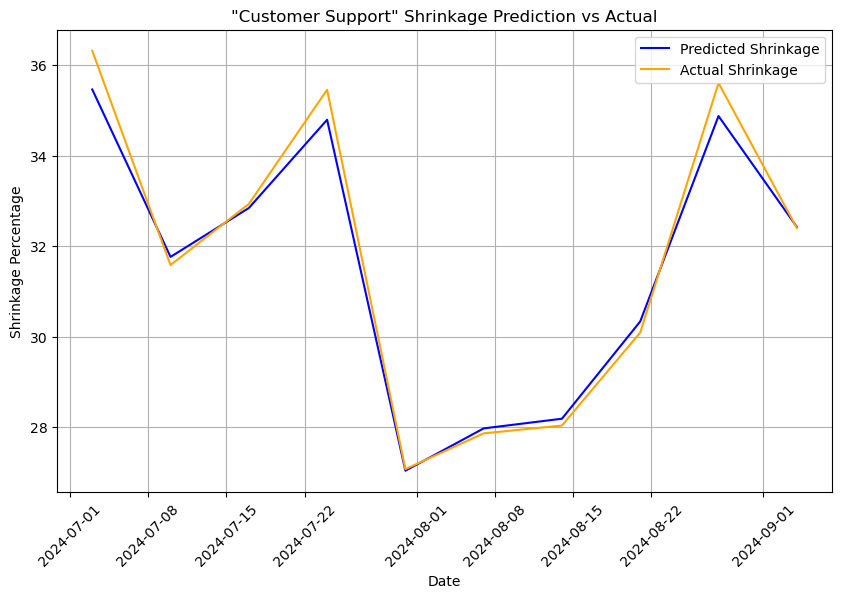

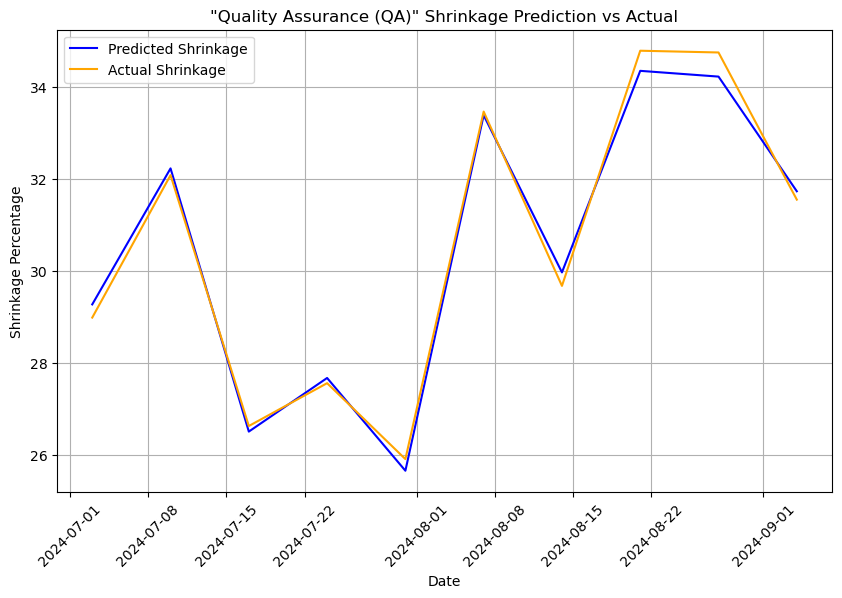

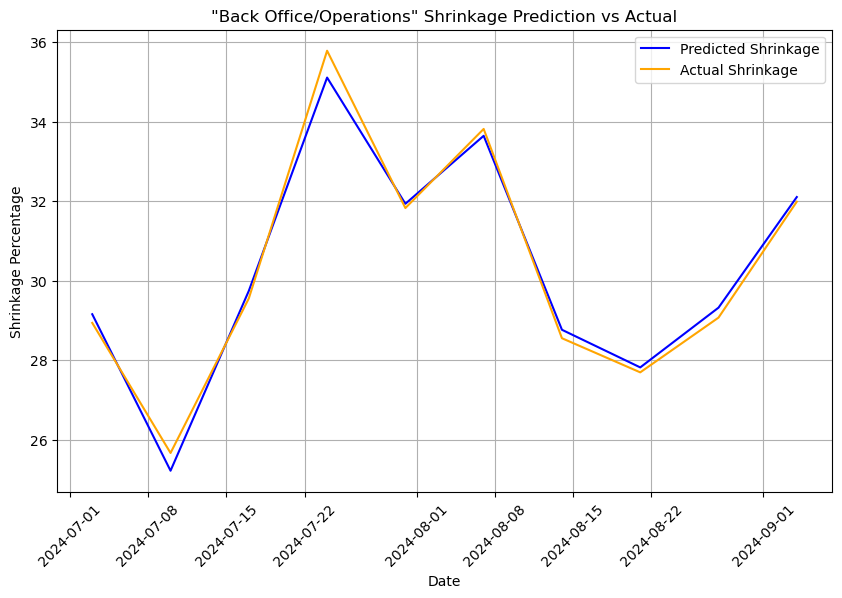

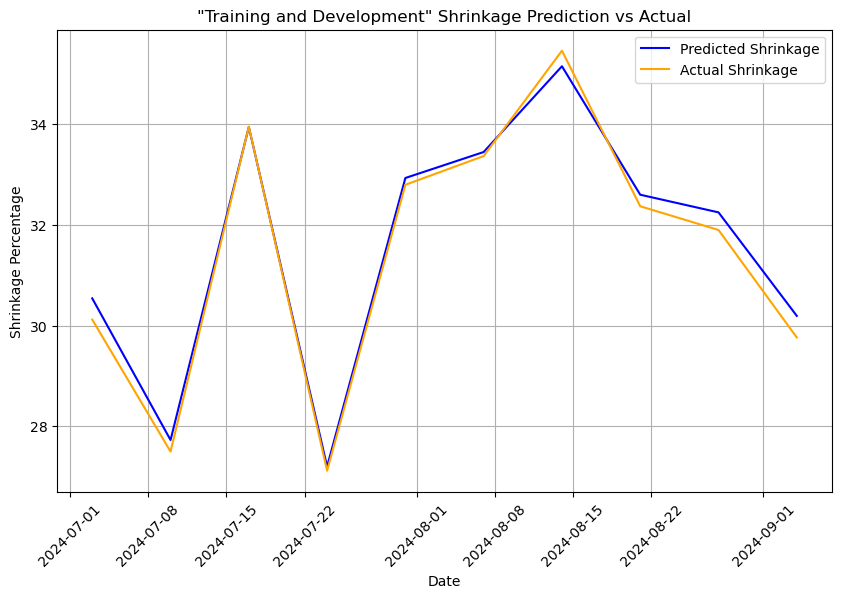

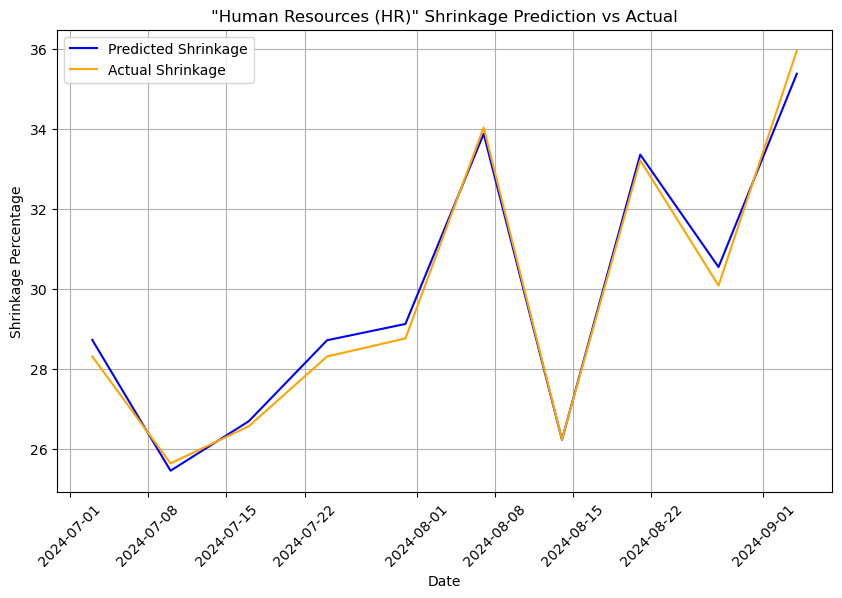

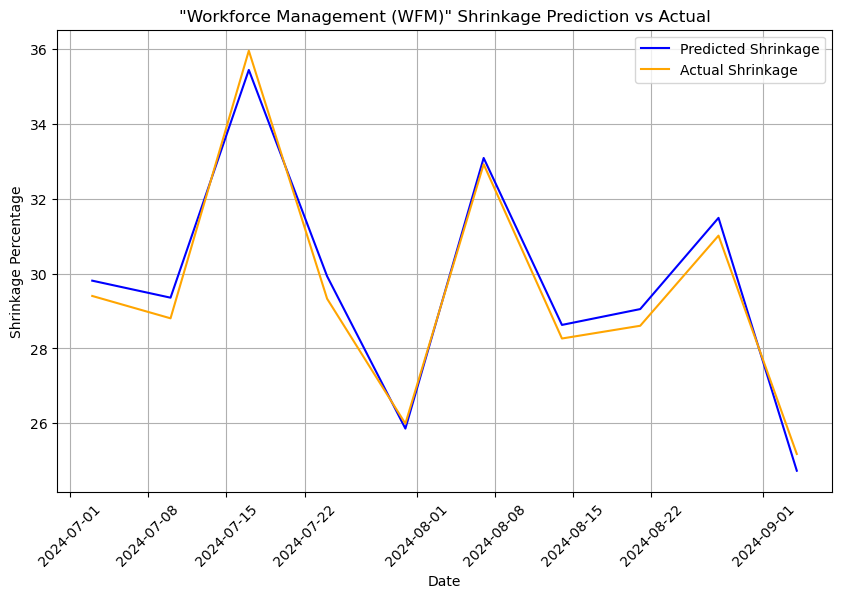

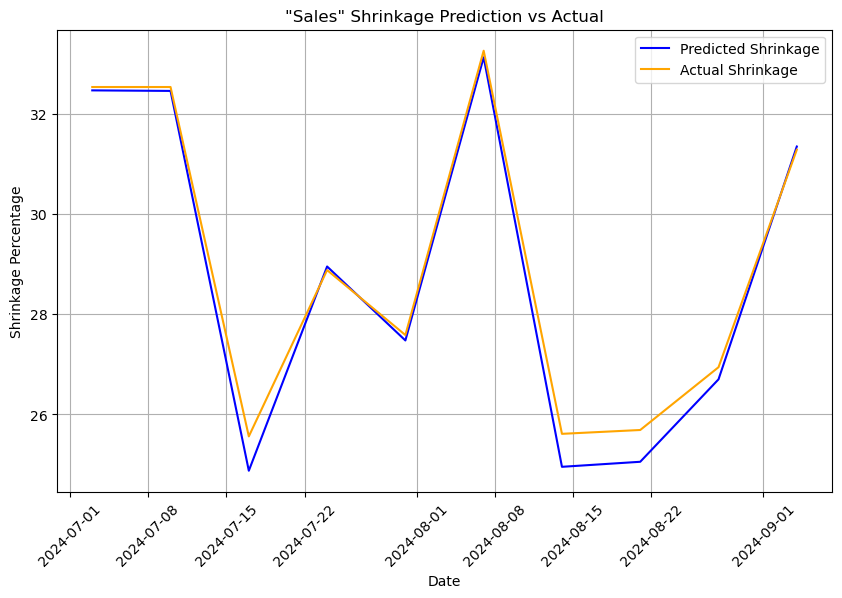

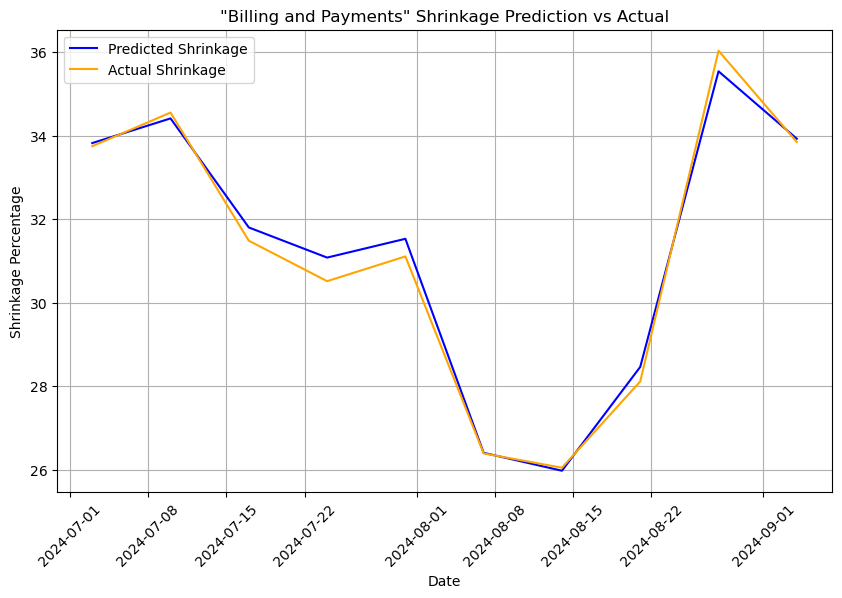

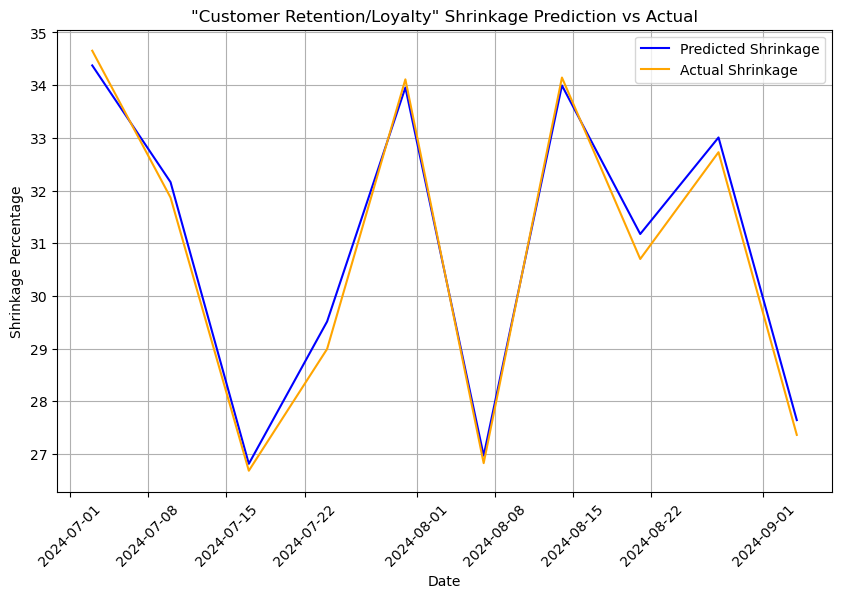

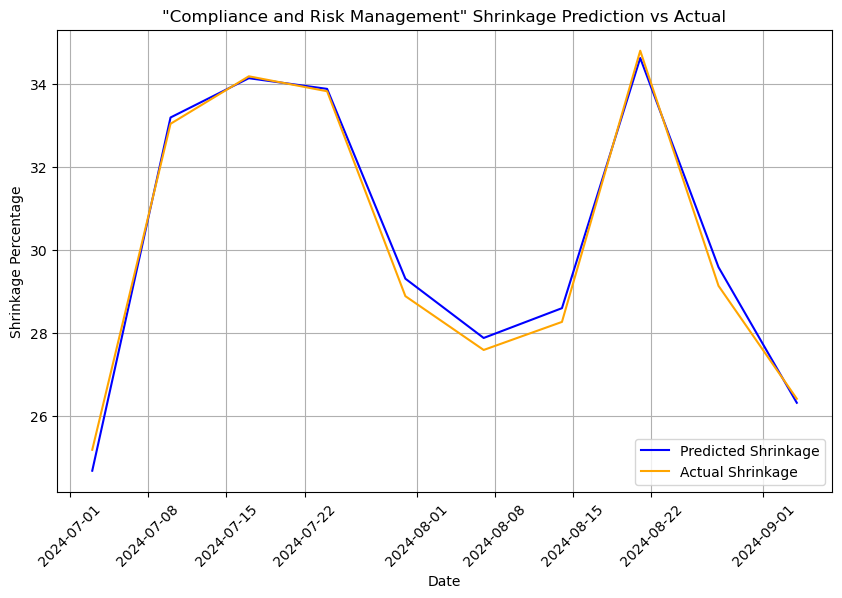

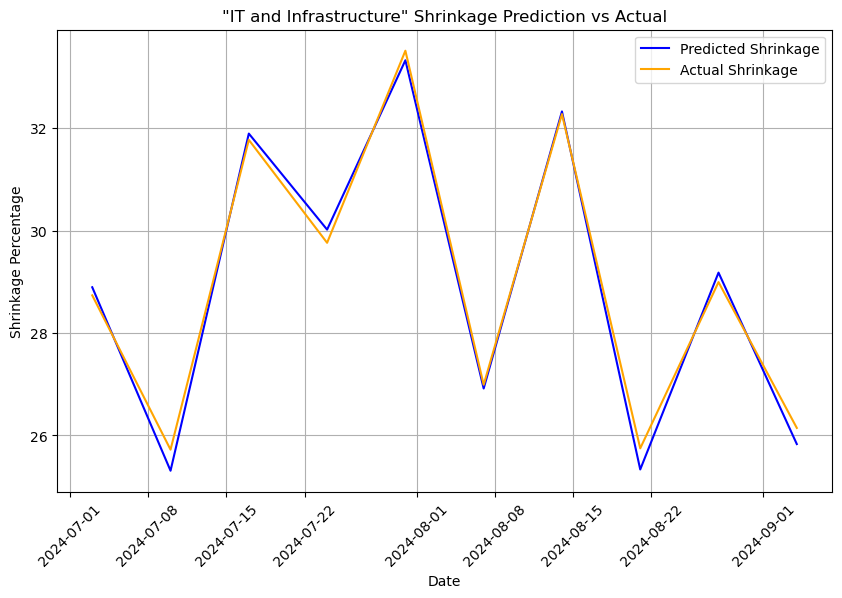

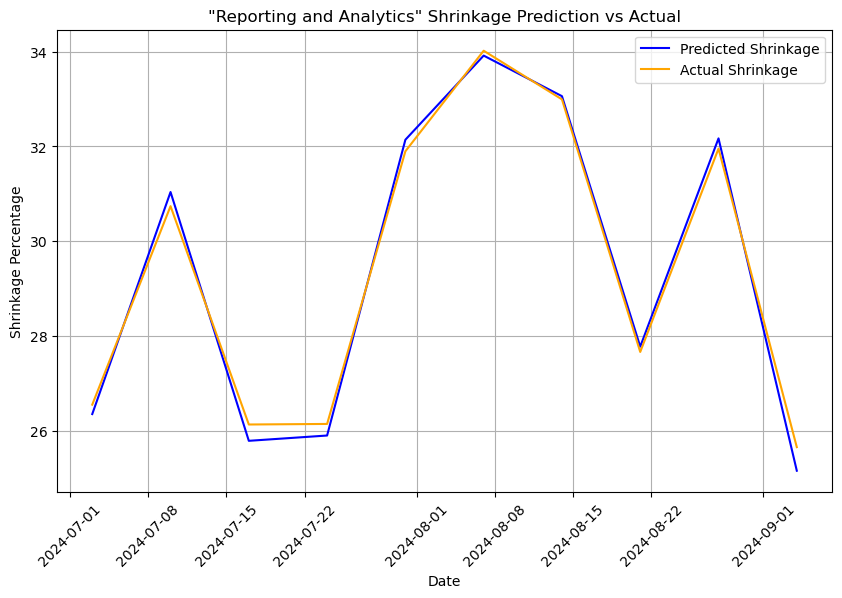

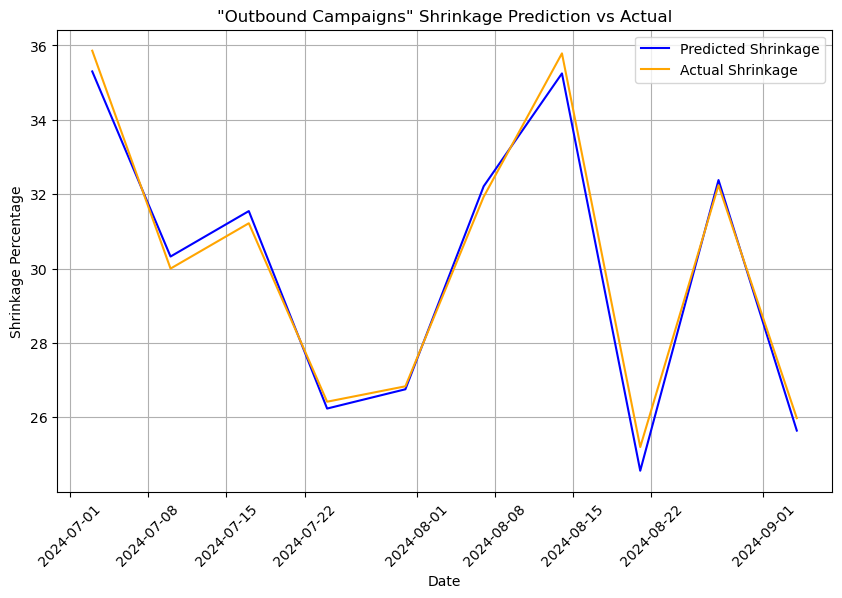

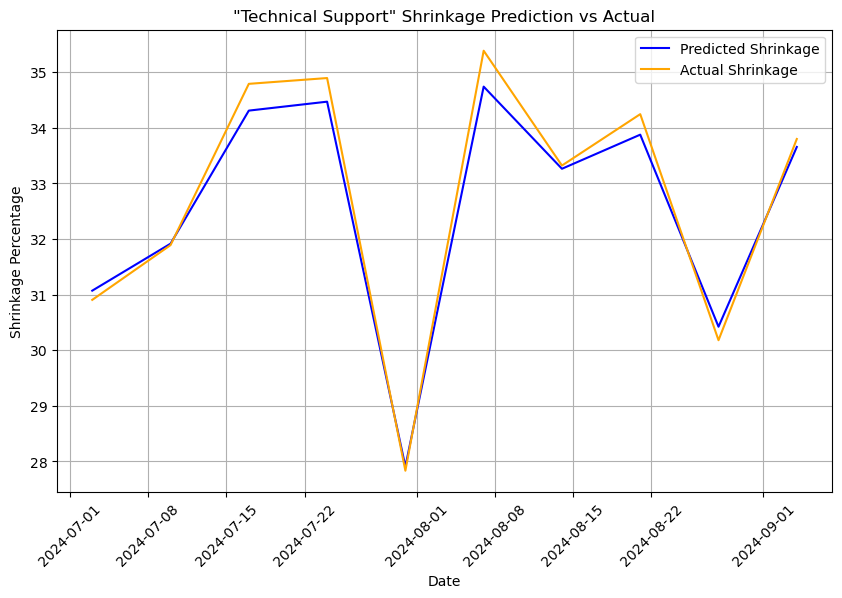

In [7]:
df1={0:'Customer Support', 1:'Quality Assurance (QA)', 2:'Back Office/Operations', 
                                   3:'Training and Development', 4:'Human Resources (HR)', 5:'Workforce Management (WFM)', 
                                   6:'Sales', 7:'Billing and Payments', 8:'Customer Retention/Loyalty', 
                                   9:'Compliance and Risk Management', 10:'IT and Infrastructure', 
                                   11:'Reporting and Analytics', 12:'Outbound Campaigns', 13:'Technical Support'}
import matplotlib.pyplot as plt

# Loop through each segment to plot
for segment in df['Segment'].unique():
    segment_key = f'Shrinkage_Percentage_Segment_{segment}'
    if segment_key in forecasts:
        plt.figure(figsize=(10, 6))
        
        # Plot predicted shrinkage using the Date column for the x-axis
        plt.plot(test_df[test_df['Segment'] == segment]['Date'], forecasts[segment_key], 
                 label='Predicted Shrinkage', color='blue')
        
        # Plot actual shrinkage using the Date column for the x-axis
        plt.plot(test_df[test_df['Segment'] == segment]['Date'], 
                 test_df[test_df['Segment'] == segment]['Shrinkage_Percentage'], 
                 label='Actual Shrinkage', color='orange')
        
        # Set plot labels and title
        plt.title(f'"{df1[segment]}" Shrinkage Prediction vs Actual')
        plt.xlabel('Date')
        plt.ylabel('Shrinkage Percentage')
        plt.xticks(rotation=45)  # Rotate the date labels for better readability
        plt.legend()
        plt.grid(True)
        plt.show()